In [17]:
# import important stuff
import numpy as np
import pandas as pd

In [18]:
# import visulization modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
%matplotlib inline


import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) 

In [19]:
# import sklearn modules
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

In [20]:
# import word cloud module 
from os import path
from wordcloud import WordCloud

# import datetime
from datetime import datetime

In [6]:
# import the data from csv file with a series of NAN values 
df= pd.read_csv('./../Consumer_Complaints_sample.csv',parse_dates=['Date received', 'Date sent to company'])

In [21]:
# Overlook of the data set
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104588 entries, 0 to 104587
Data columns (total 20 columns):
Unnamed: 0                      104588 non-null int64
Date received                   104588 non-null datetime64[ns]
Product                         104588 non-null object
Sub-product                     81021 non-null object
Issue                           104588 non-null object
Sub-issue                       54877 non-null object
Consumer complaint narrative    28579 non-null object
Company public response         32819 non-null object
Company                         104588 non-null object
State                           103344 non-null object
ZIP code                        102887 non-null object
Tags                            14505 non-null object
Consumer consent provided?      50815 non-null object
Submitted via                   104588 non-null object
Date sent to company            104588 non-null datetime64[ns]
Company response to consumer    104588 non-null object


In [22]:
df['Date received'][0]

Timestamp('2015-03-20 00:00:00')

In [23]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [24]:
df['receive month'] = df['Date received'].apply(lambda x: month_order[x.month-1])

month_df = pd.DataFrame(df['receive month'].value_counts()).reset_index()
month_df.columns = ['Month', 'Complaints']

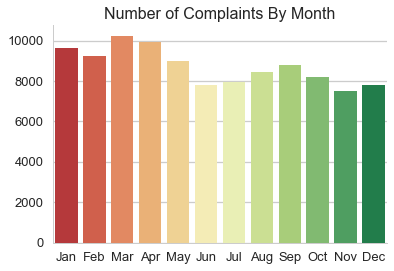

In [25]:
sns.barplot(x='Month', y='Complaints', data=month_df, order=month_order, palette="RdYlGn")
plt.title('Number of Complaints By Month',fontsize=16)
sns.despine()
plt.xlabel('')
plt.ylabel('')
plt.savefig('./../results/monthly_complaints.png', bbox_inches='tight', dpi = 150)
sns.set_style('whitegrid')

Consumer disputed? receive month        No       Yes
0                            Apr  0.826904  0.173096
1                            Aug  0.809334  0.190666
2                            Dec  0.808694  0.191306
3                            Feb  0.813157  0.186843
4                            Jan  0.816369  0.183631
5                            Jul  0.801177  0.198823
6                            Jun  0.778944  0.221056
7                            Mar  0.816709  0.183291
8                            May  0.794624  0.205376
9                            Nov  0.820352  0.179648
10                           Oct  0.804426  0.195574
11                           Sep  0.805519  0.194481


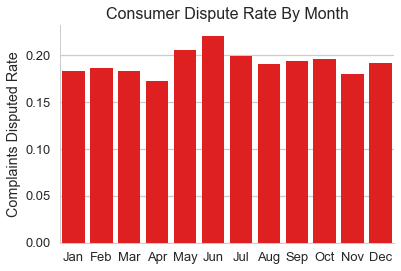

In [26]:
df_dispute_avail = df.dropna(axis=0, subset=['Consumer disputed?'])
df_dispute_month = df_dispute_avail.groupby('receive month')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()
print(df_dispute_month)
sns.barplot(x='receive month', y='Yes', data = df_dispute_month, order=month_order, color='red')
plt.ylabel('Complaint disputed')
plt.title('Consumer Dispute Rate By Month',fontsize=16)
sns.set_style('whitegrid')
sns.despine()
plt.xlabel('')
plt.ylabel('Complaints Disputed Rate')
plt.savefig('./../results/month_dispute.png', bbox_inches='tight', dpi = 150)

In [27]:
# consumer complaints by day of the week 

In [37]:

df['receive weekday'] = df['Date received'].apply(lambda x: day_order[x.weekday()])

df_dispute_avail = df.dropna(axis=0, subset=['Consumer disputed?'])
weekday_df = pd.DataFrame(df['receive weekday'].value_counts()).reset_index()
weekday_df.columns = ['WeekDate', 'Complaints']

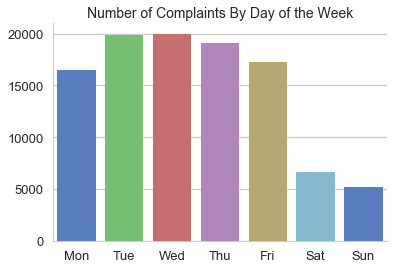

In [38]:
sns.barplot(x='WeekDate', y='Complaints', data=weekday_df, order=day_order, palette='muted')
plt.title('Number of Complaints By Day of the Week',fontsize=14)
sns.set_style('whitegrid')
sns.despine()
plt.xlabel('')
plt.ylabel('')
plt.savefig('./../results/weekly_complaints.png', bbox_inches='tight', dpi = 150)


Consumer disputed? receive weekday        No       Yes
0                              Fri  0.811732  0.188268
1                              Mon  0.803153  0.196847
2                              Sat  0.775501  0.224499
3                              Sun  0.774548  0.225452
4                              Thu  0.815747  0.184253
5                              Tue  0.812298  0.187702
6                              Wed  0.817999  0.182001


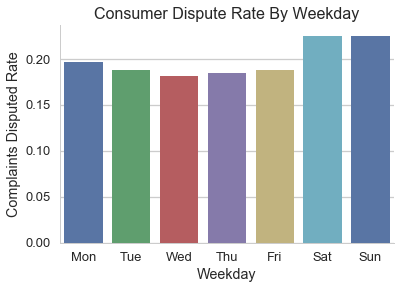

In [39]:
df_dispute_weekday = df_dispute_avail.groupby('receive weekday')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()
print(df_dispute_weekday)
sns.barplot(x='receive weekday', y='Yes', data = df_dispute_weekday, order=day_order, palette="deep")
plt.ylabel('Complaint disputed')
plt.title('Consumer Dispute Rate By Weekday',fontsize=16)
sns.set_style('whitegrid')
sns.despine()
plt.xlabel('Weekday')
plt.ylabel('Complaints Disputed Rate')
plt.savefig('./../results/weekday_dispute.png', bbox_inches='tight', dpi = 150)



### Many of the product in the list were changed over the years. For example, credit card, prepaid card were in earlier years but stopped (NaN) after 2017. Instead Credit card or prepaid card feature only appears in later years. Next, I combine some of the products to simplify the product feature. This also makes it more consistent over the years. 

In [42]:
#Many products seem to be replications. Define a function here to fix that.
def categorize_feature(ls):
    new_ls = []
    for i, prod in enumerate(ls):
        if prod in ['Credit reporting', 'Credit reporting, credit repair services, or other personal consumer reports']:
            new_ls.append('Credit reporting, or other consumer reports')
        elif prod in ['Credit card', 'Prepaid card', 'Credit card or prepaid card']:
            new_ls.append('Credit card or prepaid card')
        elif prod in ['Student loan', 'Consumer Loan', 'Vehicle loan or lease', 'Payday loan', 'Payday loan, title loan, or personal loan']:
            new_ls.append('Personal loans')
        elif prod in ['Money transfer, virtual currency, or money service', 'Money transfers', 'Virtual currency']:
            new_ls.append('Money transfer, virtual currency, or money service')
        elif prod in ['Checking or savings account', 'Bank account or service']:
            new_ls.append('Bank account or service')
        else:
            new_ls.append(prod)
    return new_ls

new_list = categorize_feature(df['Product'])

In [43]:
df['Product_new'] = pd.Series(new_list)

In [44]:
# consumer complaints of only mortgage products by day of the week 

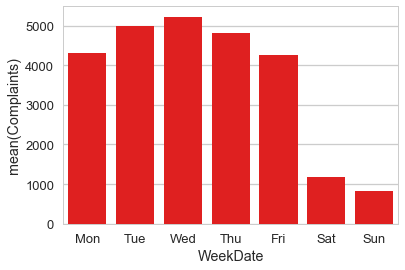

In [45]:

weekday_mortgage_df = pd.DataFrame(df[df['Product_new']=='Mortgage']['receive weekday'].value_counts()).reset_index()
weekday_mortgage_df.columns = ['WeekDate', 'Complaints']
sns.barplot(x='WeekDate', y='Complaints', data=weekday_mortgage_df, order=day_order, color='red')

In [46]:
df['Year'] = df['Date received'].apply(lambda x: x.year)

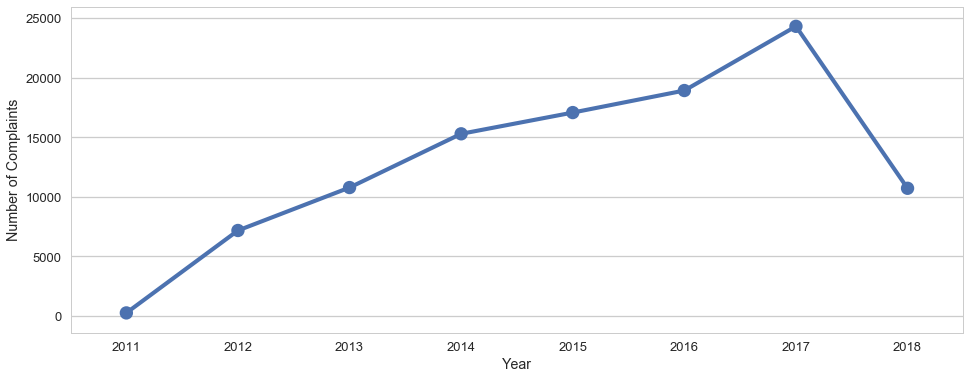

In [47]:
df_year = pd.DataFrame(df['Year'].value_counts().reset_index())
df_year.columns=['Year', 'Complaints']
plt.figure(figsize=(16,6))
sns.pointplot(x='Year', y='Complaints', data=df_year)
plt.ylabel('Number of Complaints')

In [48]:
#how many complaints for each financial product?
df_product = pd.DataFrame(df['Product'].value_counts()).reset_index()
df_product.columns = ['Product','Complaints Count']
df_product

,Product,Complaints Count
0,Mortgage,25629
1,Debt collection,20180
2,Credit reporting,13947
3,"Credit reporting, credit repair services, or o...",11963
4,Credit card,9049
5,Bank account or service,8534
6,Student loan,4429
7,Consumer Loan,3004
8,Credit card or prepaid card,2487
9,Checking or savings account,2135


In [49]:
# The product list above seem overlapping with each other. Check the appearance year of the complaints for each product. 
df.groupby('Product')['Year'].value_counts(normalize=True).unstack()

Year,2011,2012,2013,2014,2015,2016,2017,2018
Product,,,,,,,,
Bank account or service,NaN,0.136864,0.154910,0.168620,0.207288,0.247715,0.084603,NaN
Checking or savings account,NaN,NaN,NaN,NaN,NaN,NaN,0.613115,0.386885
Consumer Loan,NaN,0.059920,0.094208,0.174434,0.240679,0.315246,0.115513,NaN
Credit card,0.014698,0.169853,0.152835,0.151508,0.197922,0.233396,0.079788,NaN
Credit card or prepaid card,NaN,NaN,NaN,NaN,NaN,NaN,0.608766,0.391234
Credit reporting,NaN,0.013838,0.104395,0.208289,0.251309,0.310533,0.111637,NaN
"Credit reporting, credit repair services, or other personal consumer reports",NaN,NaN,NaN,NaN,NaN,NaN,0.618156,0.381844
Debt collection,NaN,NaN,0.053865,0.189841,0.202131,0.201041,0.240833,0.112289
"Money transfer, virtual currency, or money service",NaN,NaN,NaN,NaN,NaN,NaN,0.534338,0.465662


How many complaints per product:
Credit reporting, or other consumer reports           25910
Mortgage                                              25629
Debt collection                                       20180
Credit card or prepaid card                           11867
Bank account or service                               10669
Personal loans                                         9074
Money transfer, virtual currency, or money service     1161
Other financial service                                  98
dtype: int64


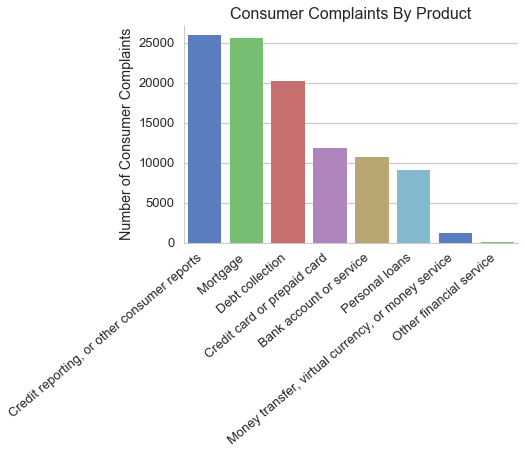

In [50]:
# Value counts of the simplified product list 
product_order = pd.Series(new_list).value_counts().index
print('How many complaints per product:')
print(pd.Series(new_list).value_counts())

sns.countplot(data=df, x='Product_new', order = product_order, palette='muted')
plt.xticks(rotation=40, ha="right")
plt.title('Consumer Complaints By Product',fontsize=16)
sns.set_style('whitegrid')
sns.despine()
plt.xlabel('')
plt.ylabel('Number of Consumer Complaints')
plt.savefig('./../results/product_complaints.png', bbox_inches='tight', dpi = 150)

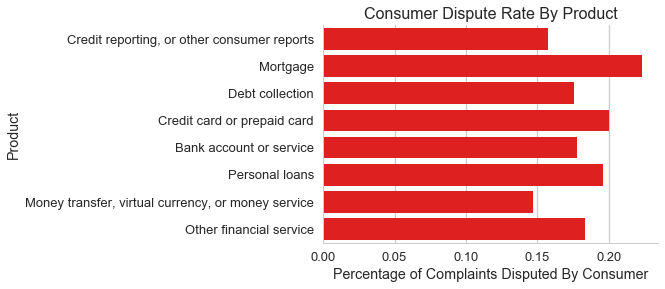

In [51]:
# Percentage of complaints being disputed for the simplified products

df_dispute = df.dropna(axis=0, subset=['Consumer disputed?'])
df_dispute_product = df_dispute.groupby('Product_new')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()

sns.barplot(data=df_dispute_product, y='Product_new', x='Yes',order = product_order, color='red')

#sns.barplot(data=df_dispute, x='Product_new', hue='Consumer disputed?',order = pd.Series(new_list).value_counts().index)

plt.title('Consumer Dispute Rate By Product',fontsize=16)
sns.set_style('whitegrid')
sns.despine()
plt.xlabel('Percentage of Complaints Disputed By Consumer')
plt.ylabel('Product')
plt.savefig('./../results/dispute_product.png', bbox_inches='tight', dpi = 150)

In [52]:
# check the sub-product feature:
df[df['Product_new']=='Mortgage']['Sub-product'].value_counts()

Other mortgage                                8811
Conventional fixed mortgage                   6913
FHA mortgage                                  2827
Conventional adjustable mortgage (ARM)        2603
Conventional home mortgage                    1573
Home equity loan or line of credit            1167
VA mortgage                                    672
Other type of mortgage                         575
Reverse mortgage                               234
Home equity loan or line of credit (HELOC)     194
Second mortgage                                 60
Name: Sub-product, dtype: int64

In [53]:
# Found code and state name data from https://www.census.gov/geo/reference/ansi_statetables.html
# change the code and state name into dictionary for later use.
state_code= pd.read_csv('./../us states code.csv')
code = state_code['STATE|STUSAB|STATE_NAME|STATENS'].apply(lambda x : x.split('|')[1])
state_name = state_code['STATE|STUSAB|STATE_NAME|STATENS'].apply(lambda x : x.split('|')[2])
state_dict = dict(zip(code, state_name))
state_dict['AA'] = 'American Armed Forces'
state_dict['AE'] = 'American Armed Forces'
state_dict['AP'] = 'American Armed Forces'
state_dict['FM'] = 'Micronesia'
state_dict['MH'] = 'Marshall Islands'
state_dict['PW'] = 'Palau'
state_dict['UNITED STATES MINOR OUTLYING ISLANDS'] = 'UNITED STATES MINOR OUTLYING ISLANDS'

In [54]:
# build a new data frame of the consumer complaints count and products count for each state. 
state_product = df.groupby('State')['Product_new'].value_counts().unstack().reset_index()
state_count = pd.DataFrame(df['State'].value_counts()).reset_index()
state_count.columns = ['State','Count']
state = state_product.merge(state_count, on = 'State')
product_list = state_product.columns[1:]

# find the most complained product for each state. Find the full name of the each state code. 
# Combine the information into one text column that will be used for interactive plotting next.  
state_max_product = []
state_max_product_count = []
for index, row in state_product.iterrows():
    max_product_count = 0
    state_name_i = state_dict[row['State']]
    for i in product_list:
        if row[i] > max_product_count:
            max_product_count = row[i]
            product_name = i
    state_max_product.append(state_name_i+"<br>"+ product_name+": "+str(max_product_count))
state['state_max_product'] = state_max_product 

state

,State,Bank account or service,Credit card or prepaid card,"Credit reporting, or other consumer reports",Debt collection,"Money transfer, virtual currency, or money service",Mortgage,Other financial service,Personal loans,Count,state_max_product
0,AA,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2,American Armed Forces<br>Bank account or servi...
1,AE,2.0,5.0,6.0,5.0,1.0,4.0,NaN,7.0,30,American Armed Forces<br>Personal loans: 7.0
2,AK,7.0,15.0,29.0,28.0,3.0,17.0,NaN,4.0,103,"Alaska<br>Credit reporting, or other consumer ..."
3,AL,106.0,104.0,374.0,261.0,5.0,204.0,NaN,145.0,1199,"Alabama<br>Credit reporting, or other consumer..."
4,AP,2.0,4.0,10.0,7.0,1.0,5.0,NaN,5.0,34,"American Armed Forces<br>Credit reporting, or ..."
5,AR,34.0,52.0,127.0,101.0,5.0,77.0,NaN,41.0,437,"Arkansas<br>Credit reporting, or other consume..."
6,AS,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,3,American Samoa<br>Credit card or prepaid card:...
7,AZ,252.0,302.0,504.0,430.0,28.0,580.0,2.0,205.0,2303,Arizona<br>Mortgage: 580.0
8,CA,1489.0,1608.0,3229.0,2611.0,168.0,4353.0,20.0,1091.0,14569,California<br>Mortgage: 4353.0
9,CO,130.0,220.0,341.0,336.0,23.0,463.0,1.0,167.0,1681,Colorado<br>Mortgage: 463.0


In [57]:
plotly_data = dict(type='choropleth',
            colorscale = 'YIOrRd',
            locations = state['State'],
            z = state['Count'],
            locationmode = 'USA-states',
            text = state['state_max_product'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"Millions USD"}
            ) 

layout = dict(title = 'Financial Products Consumer Complaints by State',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )

In [58]:
choromap = go.Figure(data = [plotly_data],layout = layout)
iplot(choromap)

In [55]:
# check the value counts of the 'Issue' feature
df['Issue'].value_counts()
df['Issue'].nunique()

163

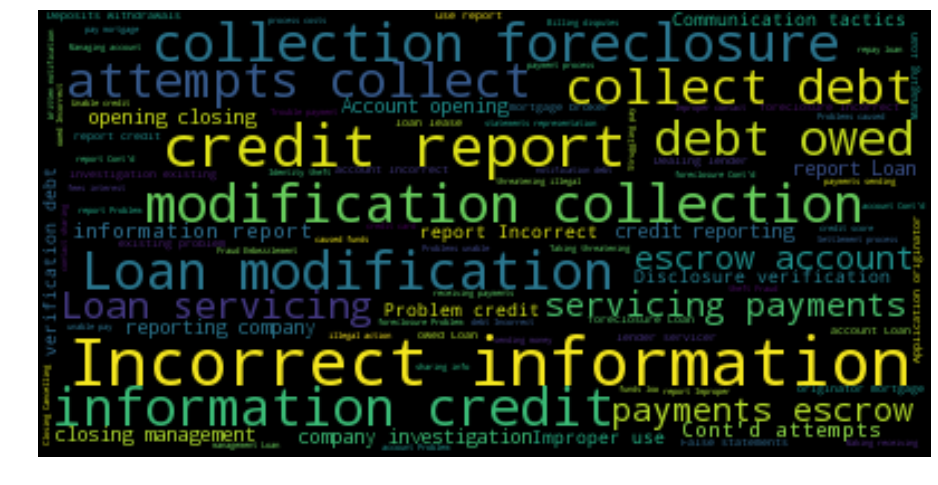

In [56]:
# Word cloud from issue

all_tags = []
for iter_row, row in df.iterrows():
    my_tags = row['Issue'].split(',')
    for tag in my_tags:
        all_tags.append(tag)


#Read the whole text.
text = ' '.join(all_tags)

text
# Generate a word cloud image
wordcloud = WordCloud(max_font_size=40).generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('./../results/issue_wordcloud.png',bbox_inches='tight', dpi = 150)
plt.show()

In [59]:
top_issue = list(pd.DataFrame(df['Issue'].value_counts()[0:30]).index)

df_top_issue = df[df['Issue'].isin(top_issue)]

In [60]:
df_top_issue['Issue'].value_counts().head(5)

Loan modification,collection,foreclosure    11305
Incorrect information on credit report      10198
Loan servicing, payments, escrow account     7744
Incorrect information on your report         6809
Cont'd attempts collect debt not owed        6169
Name: Issue, dtype: int64

In [61]:
top_company = list(pd.DataFrame(df_top_issue.Company.value_counts()[0:30]).index)
df_top_issue_comp = df_top_issue[df_top_issue['Company'].isin(top_company)]

In [62]:
df_top_issue_comp['Company'].value_counts().head(5)

EQUIFAX, INC.                             7863
Experian Information Solutions Inc.       7055
TRANSUNION INTERMEDIATE HOLDINGS, INC.    6329
BANK OF AMERICA, NATIONAL ASSOCIATION     6116
WELLS FARGO & COMPANY                     5121
Name: Company, dtype: int64

In [63]:
# choose categoric columns that we are using for initial test
categoric = df_top_issue_comp[['Product','Issue', 'Company', 'Consumer consent provided?', 'Submitted via', 'Timely response?', 'Company response to consumer']]
target_d = df_top_issue_comp['Consumer disputed?']

In [64]:
df_dummy_cate = pd.get_dummies(data=categoric, drop_first=True)
target_dummy = pd.get_dummies(data=target_d, drop_first=True)
df_dummy = df_dummy_cate.join(target_dummy)

In [65]:
#df_dummy.corr()['Yes']

Consumer disputed?     Company response to consumer        No       Yes
0                                            Closed  0.760540  0.239460
1                           Closed with explanation  0.790760  0.209240
2                       Closed with monetary relief  0.900292  0.099708
3                   Closed with non-monetary relief  0.879123  0.120877
4                                Closed with relief  0.840000  0.160000
5                             Closed without relief  0.727124  0.272876
6                                 Untimely response  1.000000       NaN


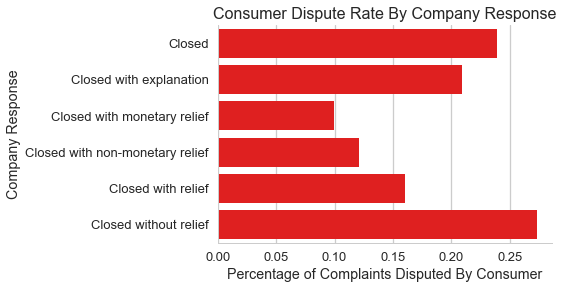

In [66]:

#check how many complaints were disputed for each company response. 
print(df_top_issue_comp.groupby('Company response to consumer')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index())
df_response = df_top_issue_comp.groupby('Company response to consumer')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()
df_response.dropna(subset=['Yes'], inplace=True)
sns.barplot(y='Company response to consumer', x='Yes', data = df_response, color='red')
plt.xlabel('Complaint disputed')
plt.title('Consumer Dispute Rate By Company Response',fontsize=16)
sns.set_style('whitegrid')
sns.despine()
plt.xlabel('Percentage of Complaints Disputed By Consumer')
plt.ylabel('Company Response')
plt.savefig('./../results/company_response_dispute.png', bbox_inches='tight', dpi = 150)

In [67]:
# find the values counts of the public response from companies
df_company_response = df.dropna(axis=0, subset=['Company public response'])
print(df_company_response['Company public response'].value_counts())
df_company_response_order = df_company_response['Company public response'].value_counts().index[0:-1]

Company has responded to the consumer and the CFPB and chooses not to provide a public response                            20681
Company chooses not to provide a public response                                                                            5349
Company believes it acted appropriately as authorized by contract or law                                                    4893
Company believes the complaint is the result of a misunderstanding                                                           472
Company disputes the facts presented in the complaint                                                                        403
Company believes complaint is the result of an isolated error                                                                317
Company believes complaint caused principally by actions of third party outside the control or direction of the company      305
Company can't verify or dispute the facts in the complaint                                       

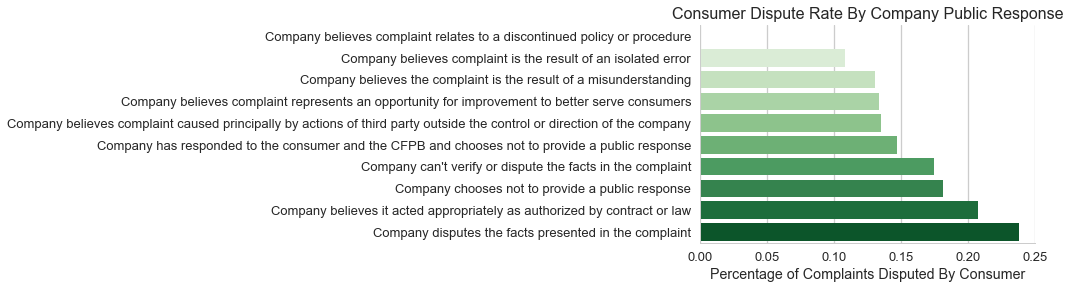

In [68]:
# disputed rate for public company responses
df_company_response_dispute = df_company_response.dropna(axis=0, subset=['Consumer disputed?'])
df_company_response_dispute_rate=df_company_response_dispute.groupby('Company public response')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()
# set value to 0 instead of NaN for one input.
df_company_response_dispute_rate.at[2, 'Yes'] =0
sns.barplot(y='Company public response', x='Yes', data = df_company_response_dispute_rate.sort_values('Yes'), palette='Greens')
plt.title('Consumer Dispute Rate By Company Public Response',fontsize=16)
sns.set_style('whitegrid')
sns.despine()
plt.xlabel('Percentage of Complaints Disputed By Consumer')
plt.ylabel('')
plt.savefig('./../results/public_company_response_dispute.png', bbox_inches='tight', dpi = 150)

In [69]:
df['narative_bool'] = pd.isnull(df['Consumer complaint narrative'])

In [70]:
df['narative_int'] = df['narative_bool'].astype(int)

In [71]:
# did narrative or not have an effect on dispute?
df.groupby('Consumer disputed?')['narative_bool'].value_counts(normalize=True).unstack()

narative_bool,False,True
Consumer disputed?,,
No,0.205160,0.794840
Yes,0.243906,0.756094


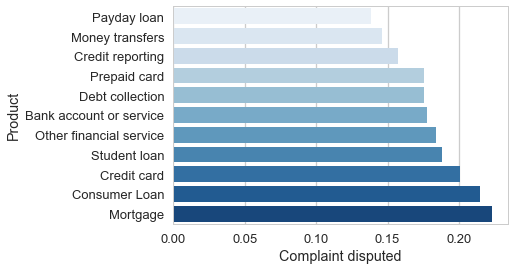

In [72]:
# any product particularly easy to be disputed?
df_product = df.groupby('Product')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()[:-1]
sns.barplot(y='Product', x='Yes', data = df_product.sort_values('Yes'), palette='Blues')
plt.xlabel('Complaint disputed')

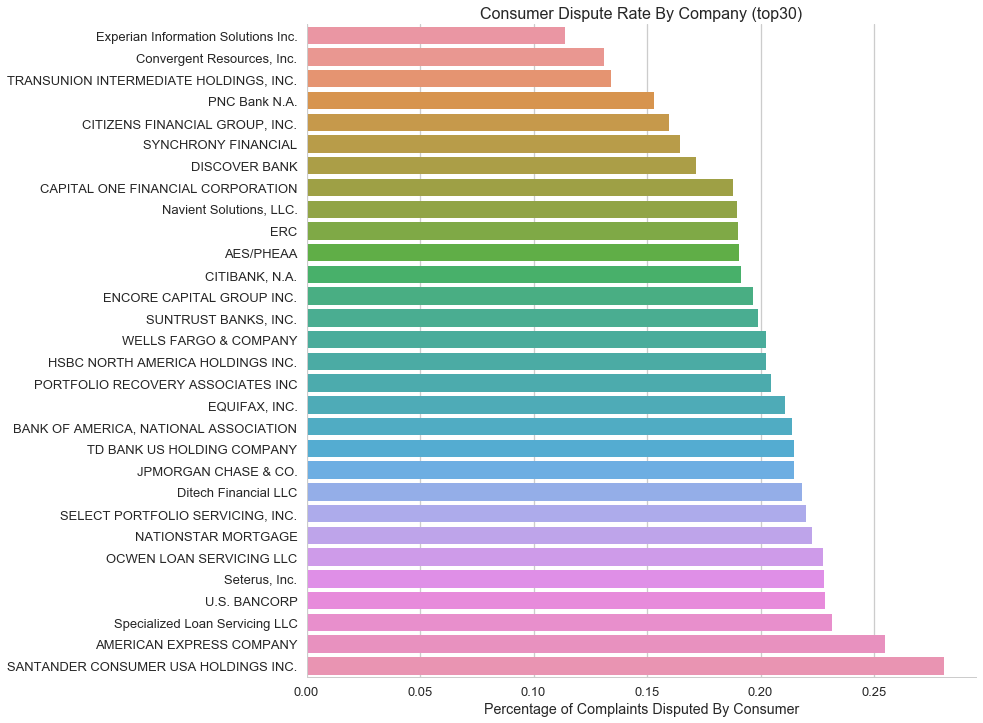

In [73]:
#most appeared companies VS disputed?

df_comp = df_top_issue_comp.groupby('Company')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()
plt.figure(figsize=(12,12))
sns.barplot(y='Company', x='Yes', data = df_comp.sort_values('Yes'))
plt.title('Consumer Dispute Rate By Company (top30)',fontsize=16)
sns.set_style('whitegrid')
sns.despine()
plt.xlabel('Percentage of Complaints Disputed By Consumer')
plt.ylabel('')
plt.savefig('./../results/company_dispute.png', bbox_inches='tight', dpi = 150)


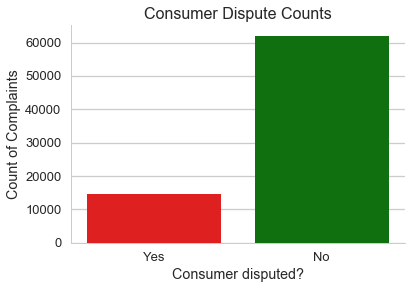

In [74]:
#check how many complaints were disputed. 
sns.countplot(df['Consumer disputed?'], palette=['red','green'])
plt.title('Consumer Dispute Counts',fontsize=16)
sns.set_style('whitegrid')
sns.despine()
plt.ylabel('Count of Complaints')
plt.savefig('./../results/complaint_dispute.png', bbox_inches='tight', dpi = 150)

In [75]:
# drop the rows where 'consumer disputed?' is missing
df.dropna(axis=0, subset=['Consumer disputed?'], inplace=True)

In [76]:

df_nara_bool = df_top_issue_comp['Consumer complaint narrative'].fillna(0)

df_nara_bool2=[]
for nara in df_nara_bool:
    if nara is not 0:
        df_nara_bool2.append(1)
    else: 
        df_nara_bool2.append(0)
        
df_top_issue_comp['Narrative_bool'] = df_nara_bool2

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [77]:
df_top_issue_comp_short = df_top_issue_comp.drop(['Unnamed: 0', 'Sub-issue', 'Company public response', 'Consumer consent provided?', 'State', 'ZIP code', 'Date sent to company', 'Date received', 'Consumer complaint narrative','Complaint ID', 'Tags'],axis=1)

In [78]:
df_top_issue_comp_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58206 entries, 0 to 104587
Data columns (total 13 columns):
Product                         58206 non-null object
Sub-product                     42641 non-null object
Issue                           58206 non-null object
Company                         58206 non-null object
Submitted via                   58206 non-null object
Company response to consumer    58206 non-null object
Timely response?                58206 non-null object
Consumer disputed?              44363 non-null object
receive month                   58206 non-null object
receive weekday                 58206 non-null object
Year                            58206 non-null int64
Product_new                     58206 non-null object
Narrative_bool                  58206 non-null int64
dtypes: int64(2), object(11)
memory usage: 8.7+ MB


In [84]:
df_dummies = pd.get_dummies(data=df_top_issue_comp_short.drop(['Consumer disputed?','Narrative_bool'], axis=1), drop_first=True)

In [85]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58206 entries, 0 to 104587
Columns: 151 entries, Year to Product_new_Personal loans
dtypes: int64(1), uint8(150)
memory usage: 11.7 MB


In [81]:
# Identify variables
X = df_dummies.join(df_top_issue_comp_short['Narrative_bool'])
target_map = {'Yes': 1, 'No':0}
y = df_top_issue_comp['Consumer disputed?'].map(target_map)

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=41)


rus = RandomUnderSampler(random_state=41)
X_rus, y_rus = rus.fit_sample(X=X_train, y=y_train)
X_rus_test, y_rus_test = rus.fit_sample(X=X_test, y=y_test)

print('Raw Training Set Percent Yes: {:.1f}%'.format(
    len(y_train[y_train == 1])/len(y_train)*100))
print('Resampled Training Set Percent Yes: {}%'.format(
    len(y_rus[y_rus == 1])/len(y_rus)*100))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [82]:
#Random forest classifier parameter optimization:

rf = RandomForestClassifier()
param_grid = {"n_estimators": [100, 200, 300],
              "max_features": [75, 100],
              "max_depth": [3, 5, 10]
              }

grid_rf = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_rf.fit(X_rus, y_rus)

# Printing the best score from the model
print('Best Score:', grid_rf.best_score_)

# Saving and printing the best parameters from the model
best_params = grid_rf.best_params_
print('Best Parameters:', best_params)

NameError: name 'X_rus' is not defined

In [ ]:
#initiate a instance for classifier
rf = RandomForestClassifier(**best_params)

# Fit the classifier to the training data
rf.fit(X_rus, y_rus)

# Predict the labels of the test data: y_pred
y_pred = rf.predict(X_rus_test)

scores_rf_train = cross_val_score(rf, X_rus, y_rus, cv=5)
print('Cross Validation Accuracy Scores - Training Set: {:.5f}(+/- {:.2f})'.format(scores_rf_train.mean(), 
                                                                                 scores_rf_train.std()*2))
scores_rf_test = cross_val_score(rf, X_rus_test, y_rus_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rf_test.mean(), 
                                                                                 scores_rf_test.std()*2))

# Generate the confusion matrix and classification report
print('Confusion matrix on the test data:')
print(confusion_matrix(y_rus_test, y_pred))
print('Classification report on the test data:')
print(classification_report(y_rus_test, y_pred))

In [ ]:
len(X)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



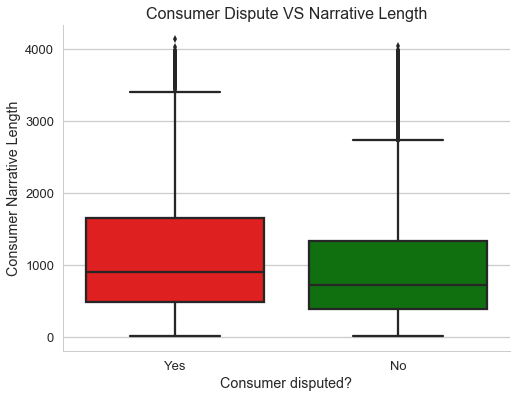

In [90]:
df_narative = df.dropna(axis=0, subset=['Consumer complaint narrative'])
df_narative['NarativeLength'] = [len(nara) for nara in df_narative['Consumer complaint narrative']]
# length of the narrative VS consumer disputed?
plt.figure(figsize=(8,6))
sns.boxplot(data=df_narative, y='NarativeLength', x='Consumer disputed?', order=['Yes', 'No'],palette=['red', 'green'])

plt.title('Consumer Dispute VS Narrative Length',fontsize=16)
sns.set_style('whitegrid')
sns.despine()
plt.ylabel('Consumer Narrative Length')
plt.xlabel('Consumer disputed?')
plt.savefig('./../results/narrativelength_dispute.png', bbox_inches='tight', dpi = 150)


In [ ]:
df_narrative_bool = df.groupby('Narrative_bool')['Consumer disputed?'].value_counts(normalize=True).unstack().reset_index()
df_narrative_bool
sns.barplot(x='Narrative_bool', y='Yes', data = df_narrative_bool.sort_values('Yes'))
plt.ylabel('Complaint disputed')
plt.xlabel('Whether Consumer Authorize Narrative')

In [92]:
#nltk.download_shell()

In [93]:
import string
from nltk.corpus import stopwords


def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [94]:
df_narative['Consumer disputed?'].value_counts()

No     12738
Yes     3582
Name: Consumer disputed?, dtype: int64

In [95]:
df_narative['Consumer complaint narrative'].head(1).apply(text_process)

2    [credit, score, ran, 2, times, Spring, Leaf, n...
Name: Consumer complaint narrative, dtype: object

In [96]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Might take awhile...
bow_transformer = CountVectorizer(analyzer=text_process).fit(df_narative['Consumer complaint narrative'])

# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

In [ ]:
narrative0 = df_narative['Consumer complaint narrative'].head(1)
print(narrative0)
bow0 = bow_transformer.transform([narrative0])

In [ ]:
narrative_bow = bow_transformer.transform(df_narative['Consumer complaint narrative'])

In [ ]:
print('Shape of Sparse Matrix: ', narrative_bow.shape)
print('Amount of Non-Zero occurences: ', narrative_bow.nnz)

In [ ]:
#transform text to TFIDF format

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(narrative_bow)

tfidf0 = tfidf_transformer.transform(bow0)

narrative_tfidf = tfidf_transformer.transform(narrative_bow)
print(narrative_tfidf.shape)

In [ ]:
#nbm = MultinomialNB().fit(narrative_tfidf, df_narative['Consumer disputed?'])
#print('predicted:', nbm.predict(tfidf0)[0])
#print('expected:',df_narative['Consumer disputed?'].head(1))

In [ ]:
#print('predicted:', nbm.predict(tfidf0)[0])
#print('expected:',df_narative['Consumer disputed?'].head(1))

In [ ]:
#random under sampling data and train-test split
from sklearn.model_selection import train_test_split

rus = RandomUnderSampler(random_state=41)
X, y = rus.fit_sample(narrative_tfidf, df_narative['Consumer disputed?'])

msg_train, msg_test, label_train, label_test = train_test_split(X, y , test_size=0.2)

#print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [ ]:
pipeline.fit(msg_train,label_train)

In [ ]:
predictions = pipeline.predict(msg_test)

In [ ]:
scores_rf_test = cross_val_score(pipeline, X_rus_test, y_rus_test, cv=5)
print('Cross Validation Accuracy Scores - Test Set: {:.5f}(+/- {:.2f})'.format(scores_rf_test.mean(), 
                                                                                 scores_rf_test.std()*2))

from sklearn.metrics import classification_report
print('Confusion matrix on the data:')
print(confusion_matrix(label_test, predictions))
print('Classification on the data:')
print (classification_report(label_test, predictions))
